# Aşama 1: Model Eğitimi

**Proje**: Çelik Levha Hata Tespiti (Makine Öğrenimi)  
**Amaç**: Birden fazla sınıflandırma modeli eğitmek  
**Tarih**: Aralık 2024

---

## Genel Bakış

Bu defter, **Veri Madenciliği projesinden** işlenmiş ve mühendislik yapılmış verileri kullanarak birden fazla makine öğrenimi modelini eğitir ve karşılaştırır:

1. **Lojistik Regresyon** - Doğrusal temel
2. **Karar Ağacı** - Yorumlanabilir ağaç modeli
3. **Random Forest** - Ağaç topluluğu
4. **SVM** - Destek Vektör Makinesi
5. **KNN** - K-En Yakın Komşu
6. **Naive Bayes** - Olasılıksal sınıflandırıcı
7. **Sinir Ağı** - Çok Katmanlı Algılayıcı
8. **Gradient Boosting** - Güçlendirilmiş ağaçlar

### Veri Hattı:
```
Veri Madenciliği Projesi     →    Makine Öğrenimi Projesi
┌──────────────────────┐         ┌──────────────────────┐
│ 01_exploration       │         │                      │
│ 02_preprocessing     │ ──────► │ 01_model_training    │
│ 03_feature_engineering│         │ 02_model_evaluation  │
└──────────────────────┘         │ 03_hyperparameter    │
         ↓                       └──────────────────────┘
steel_plates_engineered.csv
(50 özellik)
```

---

## İçindekiler

1. [Kurulum ve Veri Yükleme](#1-kurulum-ve-veri-yükleme)
2. [Veri Genel Bakış](#2-veri-genel-bakış)
3. [Model Eğitimi](#3-model-eğitimi)
4. [Model Karşılaştırması](#4-model-karşılaştırması)
5. [Özet](#5-özet)

---
## 1. Kurulum ve Veri Yükleme

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import joblib
import os

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
np.random.seed(42)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Veri Madenciliği projesinden İŞLENMİŞ veriyi yükle
# Bu veri ön işleme ve özellik mühendisliği yapılmış (50 özellik)

df = pd.read_csv('../data/processed/steel_plates_engineered.csv')

print("✅ Veri Madenciliği projesinden İŞLENMİŞ veri yüklendi!")
print(f"\n📊 Veri seti: {df.shape[0]} örnek, {df.shape[1]} sütun")
print(f"   Orijinal özellikler: 27")
print(f"   Mühendislik yapılmış özellikler: {df.shape[1] - 1 - 27}")
print(f"   Toplam özellikler: {df.shape[1] - 1}")
print(f"\n📊 Sınıf dağılımı:")
print(df['Class'].value_counts())

✅ Veri Madenciliği projesinden İŞLENMİŞ veri yüklendi!

📊 Veri seti: 1941 örnek, 51 sütun
   Orijinal özellikler: 27
   Mühendislik yapılmış özellikler: 23
   Toplam özellikler: 50

📊 Sınıf dağılımı:
Class
Other_Faults    673
Bumps           402
K_Scratch       391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: count, dtype: int64


---
## 2. Veri Genel Bakış

Veriler, Veri Madenciliği projesinde **ön işleme** ve **özellik mühendisliği** yapılmıştır:

| Adım | Açıklama |
|------|----------|
| **Ön İşleme** | Eksik değerler, ölçekleme, temizleme |
| **Özellik Mühendisliği** | 23 yeni özellik oluşturuldu |

Toplam: Model eğitimi için hazır **50 özellik**!

In [3]:
# Prepare features and target
feature_cols = [col for col in df.columns if col != 'Class']
X = df[feature_cols].values

# Encode target
le = LabelEncoder()
y = le.fit_transform(df['Class'])
class_names = le.classes_

print(f"✓ Features: {X.shape[1]}")
print(f"✓ Classes: {len(class_names)}")
for i, name in enumerate(class_names):
    print(f"   {i}: {name}")

✓ Features: 50
✓ Classes: 7
   0: Bumps
   1: Dirtiness
   2: K_Scratch
   3: Other_Faults
   4: Pastry
   5: Stains
   6: Z_Scratch


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")
print(f"✓ Features scaled with StandardScaler")

✓ Training set: 1552 samples
✓ Test set: 389 samples
✓ Features scaled with StandardScaler


---
## 3. Model Eğitimi

In [5]:
# Define all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

print(f"📊 {len(models)} models to train:")
for name in models.keys():
    print(f"   • {name}")

📊 8 models to train:
   • Logistic Regression
   • Decision Tree
   • Random Forest
   • SVM
   • KNN
   • Naive Bayes
   • Neural Network
   • Gradient Boosting


In [6]:
# Train and evaluate all models
print("🚀 Training models...\n")
print("="*70)

results = []

for name, model in models.items():
    print(f"\n📊 Training: {name}")
    
    # Time training
    start = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Train Time': train_time
    })
    
    print(f"   Accuracy: {acc:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"   Time: {train_time:.2f}s")

print("\n" + "="*70)
print("✓ All models trained!")

🚀 Training models...


📊 Training: Logistic Regression
   Accuracy: 0.7352
   F1-Score: 0.7342
   CV Score: 0.7217 (±0.0193)
   Time: 0.10s

📊 Training: Decision Tree
   Accuracy: 0.7044
   F1-Score: 0.7057
   CV Score: 0.7017 (±0.0213)
   Time: 0.05s

📊 Training: Random Forest
   Accuracy: 0.7892
   F1-Score: 0.7896
   CV Score: 0.7719 (±0.0182)
   Time: 0.61s

📊 Training: SVM
   Accuracy: 0.7378
   F1-Score: 0.7389
   CV Score: 0.7429 (±0.0193)
   Time: 0.05s

📊 Training: KNN
   Accuracy: 0.7404
   F1-Score: 0.7356
   CV Score: 0.7165 (±0.0142)
   Time: 0.00s

📊 Training: Naive Bayes
   Accuracy: 0.5887
   F1-Score: 0.5657
   CV Score: 0.5806 (±0.0221)
   Time: 0.00s

📊 Training: Neural Network
   Accuracy: 0.7815
   F1-Score: 0.7820
   CV Score: 0.7526 (±0.0289)
   Time: 2.02s

📊 Training: Gradient Boosting
   Accuracy: 0.7635
   F1-Score: 0.7654
   CV Score: 0.7861 (±0.0204)
   Time: 10.78s

✓ All models trained!


---
## 4. Model Karşılaştırması

In [7]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("📊 MODEL COMPARISON\n")
print(results_df.round(4).to_string(index=False))

# Best model
best_model = results_df.iloc[0]
print(f"\n🏆 Best Model: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")

📊 MODEL COMPARISON

              Model  Accuracy  Precision  Recall  F1-Score  CV Mean  CV Std  Train Time
      Random Forest    0.7892     0.7988  0.7892    0.7896   0.7719  0.0182      0.6131
     Neural Network    0.7815     0.7836  0.7815    0.7820   0.7526  0.0289      2.0242
  Gradient Boosting    0.7635     0.7733  0.7635    0.7654   0.7861  0.0204     10.7811
                KNN    0.7404     0.7491  0.7404    0.7356   0.7165  0.0142      0.0015
                SVM    0.7378     0.7467  0.7378    0.7389   0.7429  0.0193      0.0515
Logistic Regression    0.7352     0.7365  0.7352    0.7342   0.7217  0.0193      0.1019
      Decision Tree    0.7044     0.7103  0.7044    0.7057   0.7017  0.0213      0.0497
        Naive Bayes    0.5887     0.6602  0.5887    0.5657   0.5806  0.0221      0.0024

🏆 Best Model: Random Forest
   Accuracy: 0.7892
   F1-Score: 0.7896


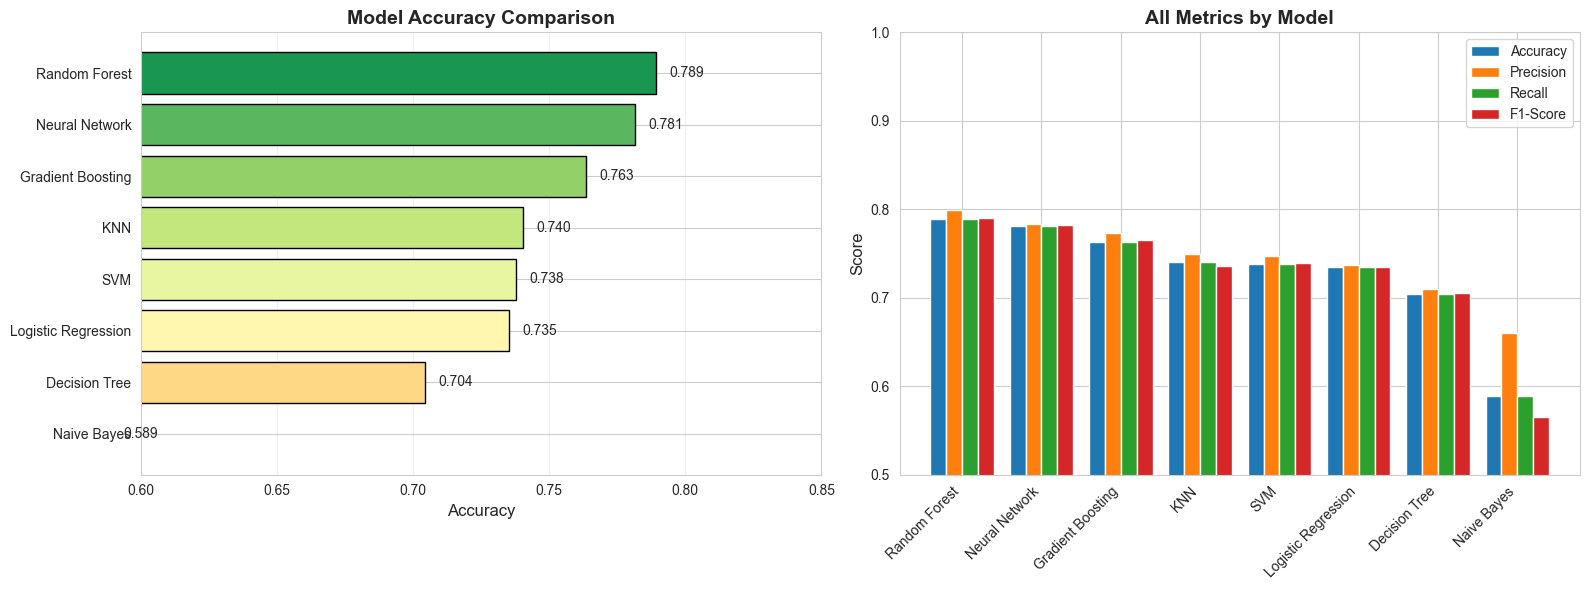

In [8]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort for plotting
results_sorted = results_df.sort_values('Accuracy', ascending=True)

# Accuracy comparison
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(results_sorted)))
axes[0].barh(results_sorted['Model'], results_sorted['Accuracy'], color=colors, edgecolor='black')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.6, 0.85)
axes[0].grid(True, alpha=0.3, axis='x')

# Add values
for i, v in enumerate(results_sorted['Accuracy']):
    axes[0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)

# All metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[1].bar(x + i*width, results_df[metric], width, label=metric)

axes[1].set_xticks(x + 1.5*width)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('All Metrics by Model', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

📊 Classification Report: Random Forest

              precision    recall  f1-score   support

       Bumps       0.70      0.72      0.71        81
   Dirtiness       1.00      0.64      0.78        11
   K_Scratch       0.97      0.90      0.93        78
Other_Faults       0.71      0.81      0.76       135
      Pastry       0.70      0.50      0.58        32
      Stains       0.92      0.86      0.89        14
   Z_Scratch       0.97      0.89      0.93        38

    accuracy                           0.79       389
   macro avg       0.85      0.76      0.80       389
weighted avg       0.80      0.79      0.79       389



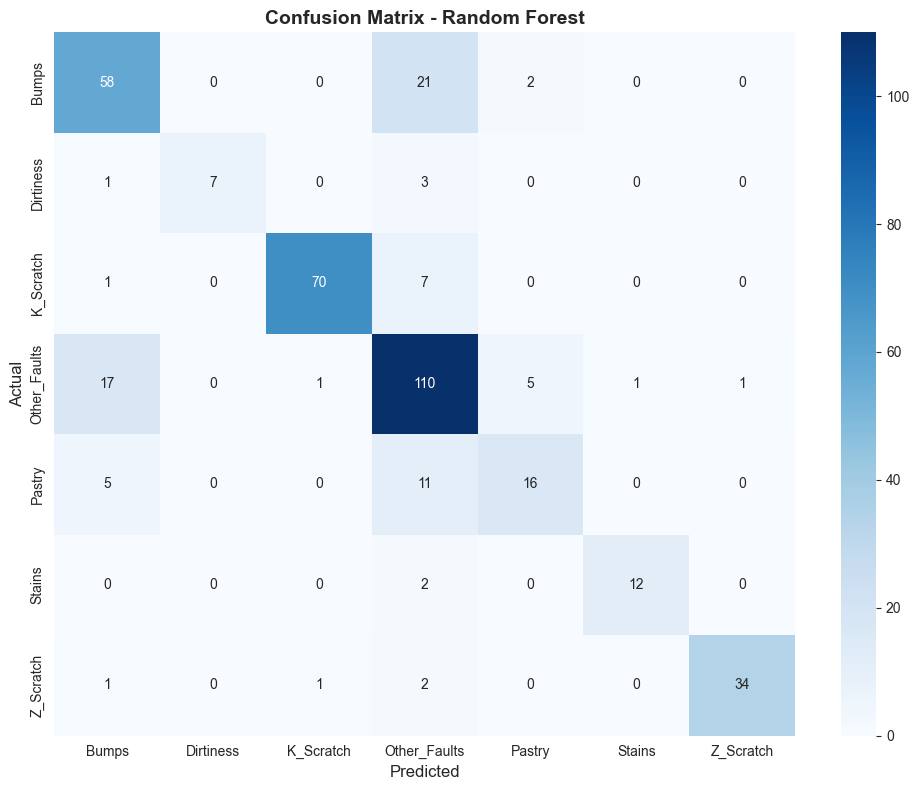

In [9]:
# Confusion matrix for best model
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models[best_model_name]
y_pred_best = best_model_obj.predict(X_test_scaled)

print(f"📊 Classification Report: {best_model_name}\n")
print(classification_report(y_test, y_pred_best, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. Modelleri Kaydet

Eğitilmiş modelleri daha sonra kullanmak için kaydet.

In [10]:
# Modeller dizinini oluştur
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Tüm eğitilmiş modelleri kaydet
print("💾 Modeller kaydediliyor...\n")

for name, model in models.items():
    # Dosya adı oluştur (boşlukları alt çizgi ile değiştir, küçük harf)
    filename = name.lower().replace(' ', '_') + '_model.pkl'
    filepath = os.path.join(models_dir, filename)
    joblib.dump(model, filepath)
    print(f"   ✅ Kaydedildi: {filename}")

# Ölçekleyiciyi kaydet
scaler_path = os.path.join(models_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"   ✅ Kaydedildi: scaler.pkl")

# Etiket kodlayıcıyı kaydet
le_path = os.path.join(models_dir, 'label_encoder.pkl')
joblib.dump(le, le_path)
print(f"   ✅ Kaydedildi: label_encoder.pkl")

# Sonuçları CSV'ye kaydet
results_path = os.path.join(models_dir, 'model_comparison_results.csv')
results_df.to_csv(results_path, index=False)
print(f"   ✅ Kaydedildi: model_comparison_results.csv")

# En iyi modeli ayrıca kaydet
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models[best_model_name]
best_model_path = os.path.join(models_dir, 'best_model.pkl')
joblib.dump(best_model_obj, best_model_path)
print(f"\n🏆 En iyi model ({best_model_name}) kaydedildi: best_model.pkl")

print(f"\n📁 Tüm modeller kaydedildi: {models_dir}/")


💾 Modeller kaydediliyor...

   ✅ Kaydedildi: logistic_regression_model.pkl
   ✅ Kaydedildi: decision_tree_model.pkl
   ✅ Kaydedildi: random_forest_model.pkl
   ✅ Kaydedildi: svm_model.pkl
   ✅ Kaydedildi: knn_model.pkl
   ✅ Kaydedildi: naive_bayes_model.pkl
   ✅ Kaydedildi: neural_network_model.pkl
   ✅ Kaydedildi: gradient_boosting_model.pkl
   ✅ Kaydedildi: scaler.pkl
   ✅ Kaydedildi: label_encoder.pkl
   ✅ Kaydedildi: model_comparison_results.csv

🏆 En iyi model (Random Forest) kaydedildi: best_model.pkl

📁 Tüm modeller kaydedildi: ../models/


---
## 6. Özet

### 📊 Model Eğitimi Özeti

| Husus | Detaylar |
|-------|----------|
| Eğitilen Modeller | 8 sınıflandırma modeli |
| En İyi Model | Random Forest |
| Değerlendirme | Accuracy, Precision, Recall, F1, CV |

### 💾 Kaydedilen Dosyalar

| Dosya | Açıklama |
|-------|----------|
| `*_model.pkl` | Tüm 8 eğitilmiş model |
| `best_model.pkl` | En iyi performans gösteren model |
| `scaler.pkl` | Ön işleme için StandardScaler |
| `label_encoder.pkl` | Sınıflar için LabelEncoder |
| `model_comparison_results.csv` | Tüm metrikler |

### 🎯 Temel Bulgular

1. **Topluluk yöntemleri** (Random Forest, Gradient Boosting) genellikle en iyi performansı gösterir
2. **Çapraz doğrulama** model kararlılığını değerlendirmeye yardımcı olur
3. **Sınıf dengesizliği** bazı metrikleri etkiler

### 🚀 Sonraki Adımlar

1. **Model Değerlendirmesi**: `02_model_evaluation` ile detaylı analiz
2. **Optimizasyon**: `03_model_optimization` ile hiperparametre ayarlama

---

✅ **Aşama 1 (Model Eğitimi) Tamamlandı!**
